In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, r2_score, mean_absolute_error

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)

# Загрузка данных
github_csv_url = 'https://raw.githubusercontent.com/popkaotarbuza/sleep-disorder-diagnosis/refs/heads/dev/src/data/Sleep_health_and_lifestyle_dataset.csv'
df = pd.read_csv(github_csv_url)

# Заполняем пропуски в Sleep Disorder значением "None"
df['Sleep Disorder'] = df['Sleep Disorder'].fillna('None')

# Разделяем артериальное давление на систолическое и диастолическое
if 'Blood Pressure' in df.columns:
    df[['Systolic_BP', 'Diastolic_BP']] = df['Blood Pressure'].str.split('/', expand=True).astype(int)
    df = df.drop(columns=['Blood Pressure'])

print(f"Данные загружены. Размер: {df.shape}")
df.head()

Данные загружены. Размер: (374, 14)


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Systolic_BP,Diastolic_BP
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,None,126,83
1,2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,None,125,80
2,3,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,None,125,80
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90


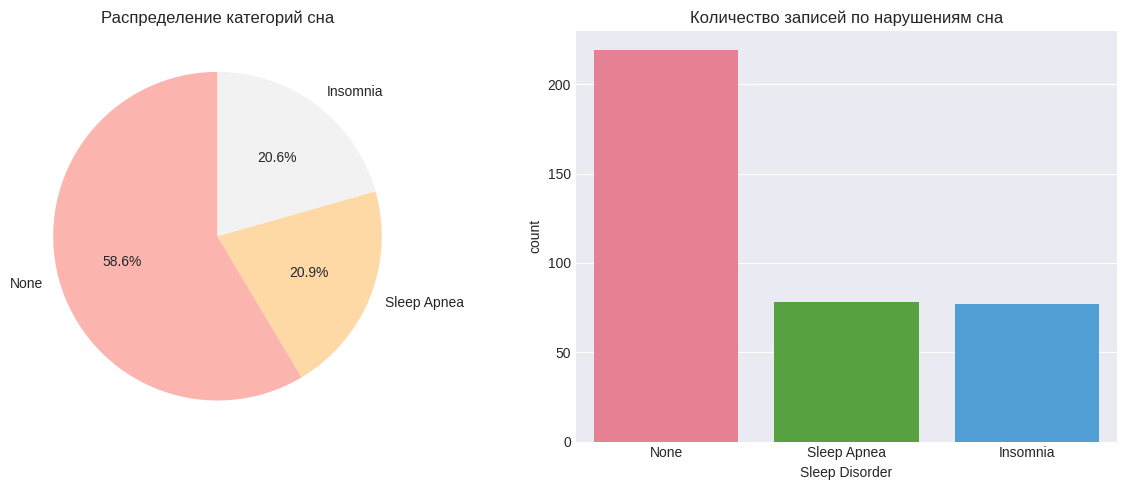

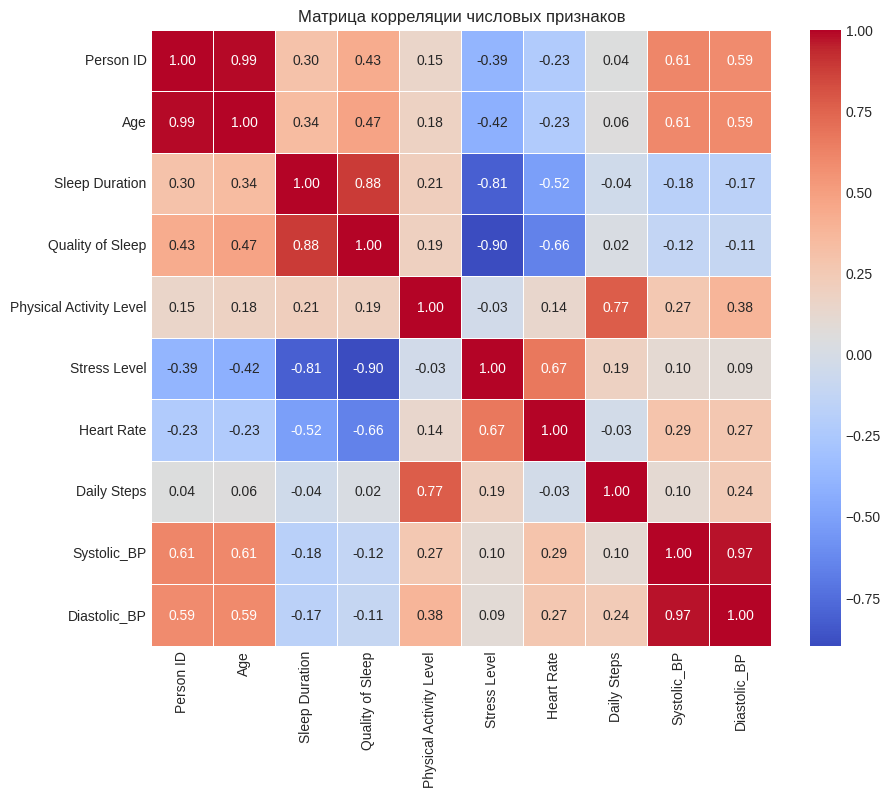

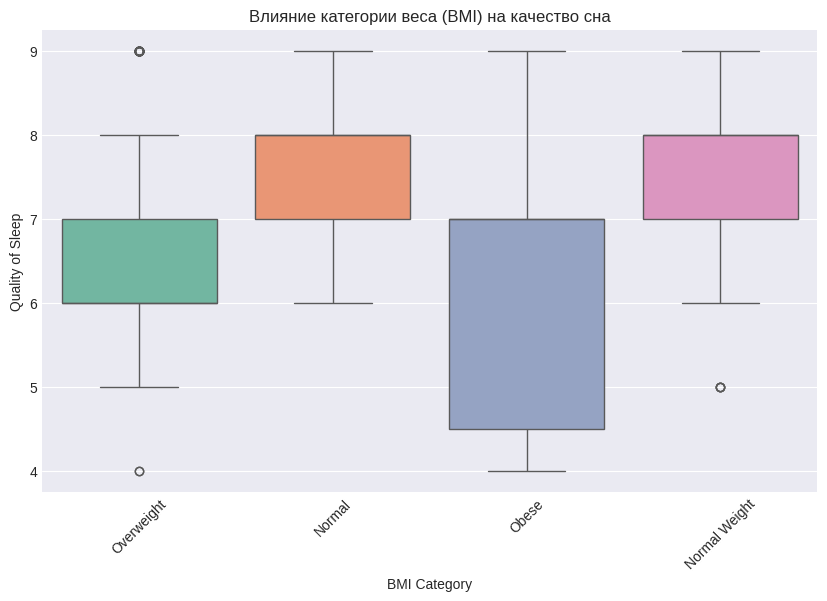

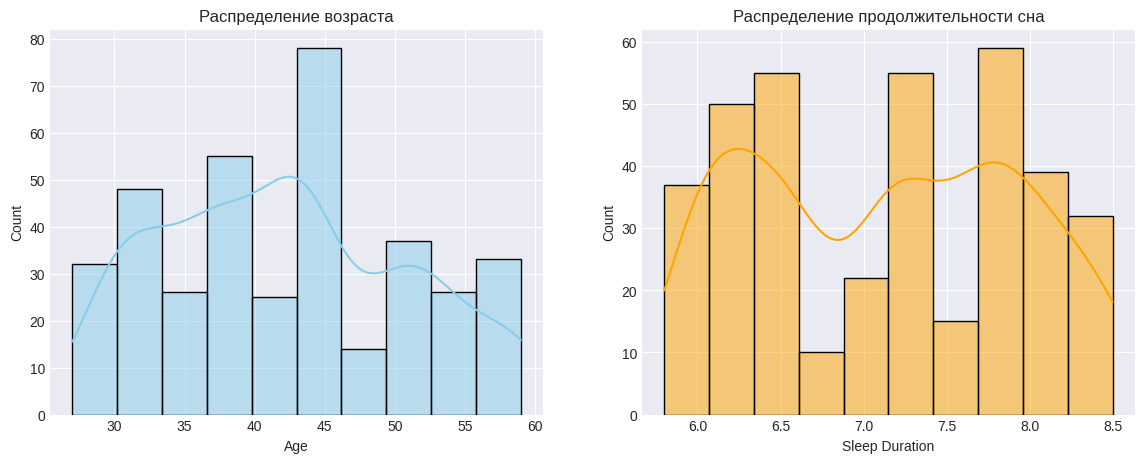

In [39]:
# Визуализация
# 1. Распределение целевой переменной
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df['Sleep Disorder'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='Pastel1')
plt.title('Распределение категорий сна')
plt.ylabel('')

plt.subplot(1, 2, 2)
sns.countplot(x='Sleep Disorder', data=df, palette='husl', hue='Sleep Disorder', legend=False)
plt.title('Количество записей по нарушениям сна')
plt.tight_layout()
plt.show()

# 2. Корреляционная матрица
# Выбираем только числовые колонки для корреляции
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Матрица корреляции числовых признаков')
plt.show()

# 3. Влияние ИМТ на качество сна
plt.figure(figsize=(10, 6))
sns.boxplot(x='BMI Category', y='Quality of Sleep', data=df, palette='Set2', hue='BMI Category', legend=False)
plt.title('Влияние категории веса (BMI) на качество сна')
plt.xticks(rotation=45)
plt.show()

# 4. Распределение возраста и длительности сна
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df['Age'], kde=True, ax=ax[0], color='skyblue')
ax[0].set_title('Распределение возраста')

sns.histplot(df['Sleep Duration'], kde=True, ax=ax[1], color='orange')
ax[1].set_title('Распределение продолжительности сна')
plt.show()

Точность модели: 0.957


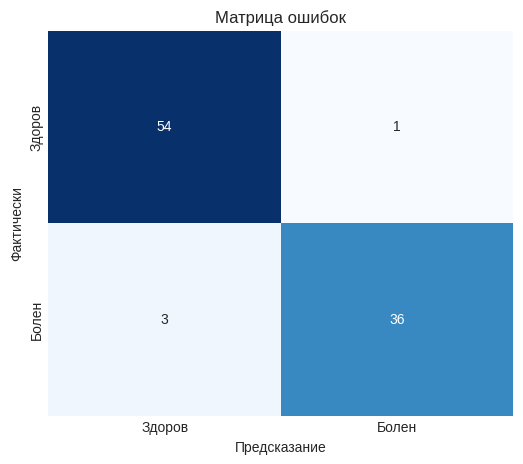

In [40]:
# Подготовка данных
le = LabelEncoder()
categorical_cols = df.select_dtypes(include=['object']).columns
df_encoded = df.copy()

for col in categorical_cols:
    if col != 'Sleep Disorder': # Целевую переменную пока не трогаем для регрессии, но для классификации закодируем
        df_encoded[col] = le.fit_transform(df[col])

# Создаем бинарную цель: 1 - есть нарушение, 0 - нет
df_encoded['Has_Disorder'] = df['Sleep Disorder'].apply(lambda x: 0 if x == 'None' else 1)

# Признаки
X = df_encoded.drop(columns=['Sleep Disorder', 'Person ID', 'Has_Disorder'])
y = df_encoded['Has_Disorder']

# Разделение
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)
y_pred = gb_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Точность модели: {acc:.3f}")

plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Здоров', 'Болен'], yticklabels=['Здоров', 'Болен'])
plt.xlabel('Предсказание')
plt.ylabel('Фактически')
plt.title('Матрица ошибок')
plt.show()

Коэффициент детерминации(R²): 0.993


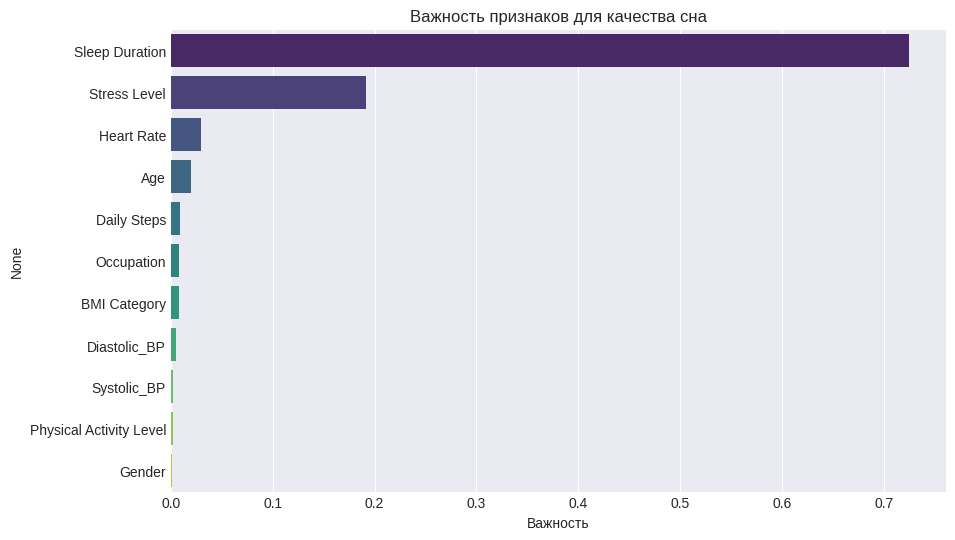

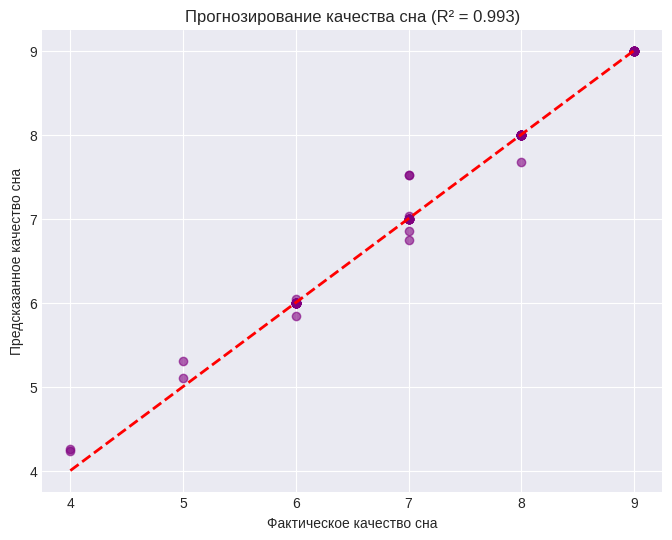

In [41]:
# Random Forest Regression: Предсказание качества сна. Целевая переменная - Quality of Sleep
y_reg = df_encoded['Quality of Sleep']
X_reg = df_encoded.drop(columns=['Sleep Disorder', 'Person ID', 'Has_Disorder', 'Quality of Sleep'])

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.25, random_state=42)

rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train_reg, y_train_reg)
y_pred_reg = rf_reg.predict(X_test_reg)

r2 = r2_score(y_test_reg, y_pred_reg)
print(f"Коэффициент детерминации(R²): {r2:.3f}")

importances = rf_reg.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_reg.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=features[indices], palette='viridis', hue=features[indices], legend=False)
plt.title('Важность признаков для качества сна')
plt.xlabel('Важность')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.6, color='purple')
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.xlabel('Фактическое качество сна')
plt.ylabel('Предсказанное качество сна')
plt.title(f'Прогнозирование качества сна (R² = {r2:.3f})')
plt.show()